In [1]:
#import numpy as np
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
import jax.scipy.stats as jsps
import jax.scipy.linalg as spla
from jax.config import config
config.update("jax_enable_x64", True)
from jax.scipy.stats import gaussian_kde

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from search_no_gpjax import generate_true_function

In [2]:
def convelope(design_space, knot_y):

    N, D = design_space.shape
    deriv_marg_var = 100
    #d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel_old(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))
    # TODO: 
    #deriv_marg_var = np.max(jnp.diag(d_kernel(knot_x, knot_x, ls)))
    #print(deriv_marg_var)
    s = jnp.linspace(-3*jnp.sqrt(deriv_marg_var), 3*jnp.sqrt(deriv_marg_var), 500)
    ss = jnp.meshgrid(*[s.ravel()]*D)
    s = jnp.array([sx.flatten() for sx in ss]).T

    knot_y = jnp.atleast_2d(knot_y) # samples x num_primal
    #print(knot_y.shape)
    
    prod = (design_space @ s.T).T
    #print(prod.shape)
    
    # compute the conjugate
    lft1 = jnp.max(prod[jnp.newaxis,:,:] - knot_y[:,jnp.newaxis,:],  axis=2) # samples x num_dual
    #print(lft1.shape)
    # compute the biconjugate
    lft2 = jnp.max(prod[jnp.newaxis,:,:] - lft1[:,:,jnp.newaxis],  axis=1) # samples x num_primal
    
    return lft2

In [7]:
import numpy as np
from scipy.spatial import ConvexHull

%matplotlib inline
import matplotlib.pyplot as plt


def convex_envelope(x, fs):
    """Computes convex envelopes of M functions which share a common grid.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (M, N)-matrix.
    The i-th function is given by the pairs (x[0], fs[i, 0]), ..., (x[N-1], fs[i, N-1]).
    The envelopes are returned as a list of lists.
    The i-th list is of the form [j_1, j_2, ..., j_n] where (X[j_k], fs[i, j_k]) is a point in the envelope.
    
    Keyword arguments:
    x  -- A shape=(N,D) numpy array.
    fs -- A shape=(M,N) or shape=(N,) numpy array."""
    
    assert(len(fs.shape) <= 2)
    if len(fs.shape) == 1: fs = np.reshape(fs, (-1, fs.shape[0]))
    M, N = fs.shape
    
    assert(len(x.shape) <= 2)
    if len(x.shape) == 1: x = np.reshape(x, (-1, 1))
    assert(x.shape[0] == N)
    D = x.shape[1]
    
    fs_pad = np.empty((M, N+2))
    fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1. ## TODO: can't do this
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    results = []
    for i in range(M):
        epi = np.column_stack((x_pad, fs_pad[i, :]))
        hull = ConvexHull(epi)
        result = [v-1 for v in hull.vertices if 0 < v <= N]
        result.sort()
        results.append(np.array(result))
    
    return np.array(results)


In [8]:
convex_envelope(design_space, true_y)[0]

array([ 0,  3, 10, 31, 44, 45, 49])

# Computations


Compare:
* 1d and 2d convex hull constructions
* biconjugate computation
* qhull + something

# 1D vs 2D

Time the current biconjugate computation

In [9]:
seed = 2
num_iters = 6
knot_N = 50
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

true_y, true_envelope = generate_true_function(design_space, knot_N)

NameError: name 'is_tight' is not defined

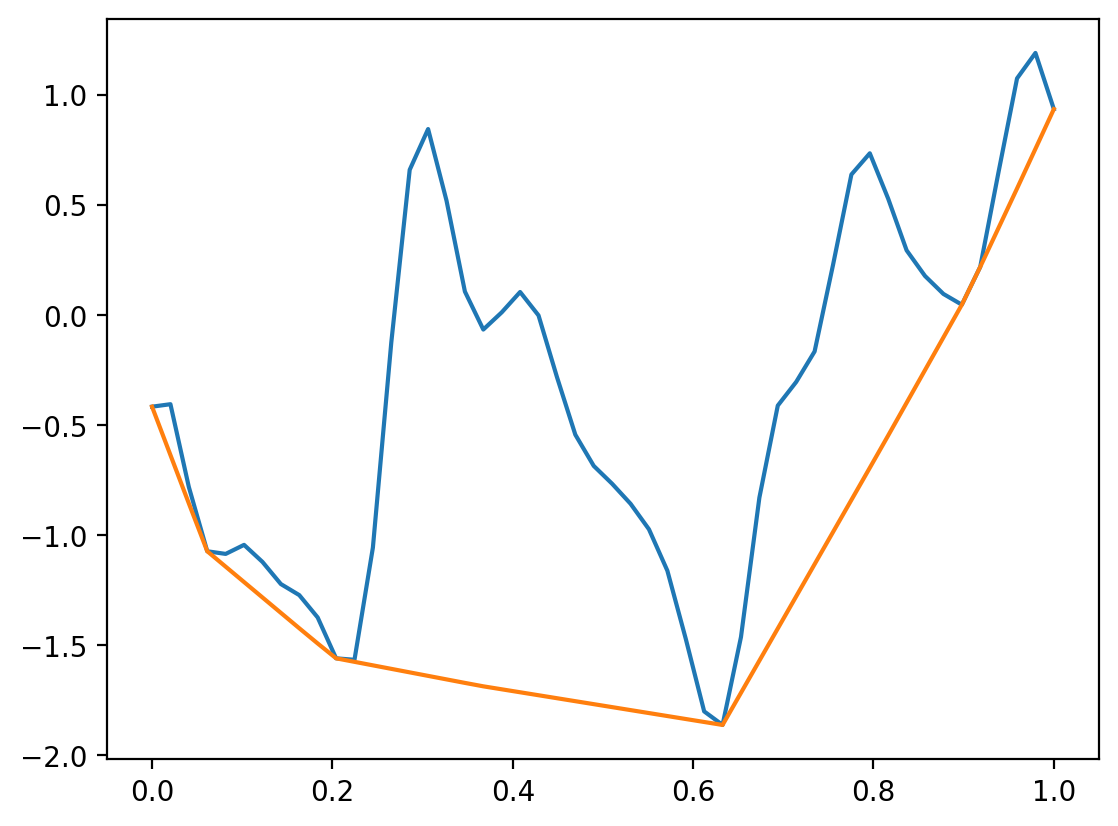

In [10]:
plt.plot(design_space, true_y)
plt.plot(design_space, true_envelope.T)

s = is_tight(design_space, true_y).astype("int32")
s_ind = np.where(s == 1)[0]
plt.scatter(design_space[s_ind], true_y[s_ind])

In [11]:
np.where(s == 1)[0]

NameError: name 's' is not defined

In [12]:
np.array(true_y)

array([-0.41675785, -0.40549095, -0.78157582, -1.07343528, -1.08550891,
       -1.04435526, -1.12179872, -1.22238809, -1.27259439, -1.37412409,
       -1.55967996, -1.56631715, -1.05678578, -0.12497541,  0.6590368 ,
        0.84428304,  0.51926492,  0.10615362, -0.06642507,  0.01167242,
        0.10416505, -0.00217376, -0.28186906, -0.54396299, -0.68578587,
       -0.76687227, -0.85768361, -0.97362762, -1.16156385, -1.4710738 ,
       -1.80072864, -1.86234451, -1.4628865 , -0.82990824, -0.41177854,
       -0.30438096, -0.16603163,  0.2265731 ,  0.6377869 ,  0.7340785 ,
        0.52757678,  0.29334309,  0.17682145,  0.09530181,  0.04643255,
        0.21836948,  0.65126816,  1.07427958,  1.18987073,  0.93480688])

In [13]:
from scipy.spatial import ConvexHull

In [14]:
np.hstack([design_space, true_y[:, np.newaxis]])

array([[ 0.        , -0.41675785],
       [ 0.02040816, -0.40549095],
       [ 0.04081633, -0.78157582],
       [ 0.06122449, -1.07343528],
       [ 0.08163265, -1.08550891],
       [ 0.10204082, -1.04435526],
       [ 0.12244898, -1.12179872],
       [ 0.14285714, -1.22238809],
       [ 0.16326531, -1.27259439],
       [ 0.18367347, -1.37412409],
       [ 0.20408163, -1.55967996],
       [ 0.2244898 , -1.56631715],
       [ 0.24489796, -1.05678578],
       [ 0.26530612, -0.12497541],
       [ 0.28571429,  0.6590368 ],
       [ 0.30612245,  0.84428304],
       [ 0.32653061,  0.51926492],
       [ 0.34693878,  0.10615362],
       [ 0.36734694, -0.06642507],
       [ 0.3877551 ,  0.01167242],
       [ 0.40816327,  0.10416505],
       [ 0.42857143, -0.00217376],
       [ 0.44897959, -0.28186906],
       [ 0.46938776, -0.54396299],
       [ 0.48979592, -0.68578587],
       [ 0.51020408, -0.76687227],
       [ 0.53061224, -0.85768361],
       [ 0.55102041, -0.97362762],
       [ 0.57142857,

In [15]:
points = np.hstack([design_space, true_y[:, np.newaxis]])
hull = ConvexHull(points)
s = np.zeros(len(design_space))
s[hull.vertices] = 1

In [16]:
hull.simplices

array([[15,  0],
       [10, 31],
       [44, 31],
       [48, 49],
       [48, 15],
       [ 3,  0],
       [ 3, 10],
       [45, 49],
       [45, 44]], dtype=int32)

In [17]:
points[hull.simplices[0]]

array([[ 0.30612245,  0.84428304],
       [ 0.        , -0.41675785]])

In [18]:
design_space[np.array(result)]

NameError: name 'result' is not defined

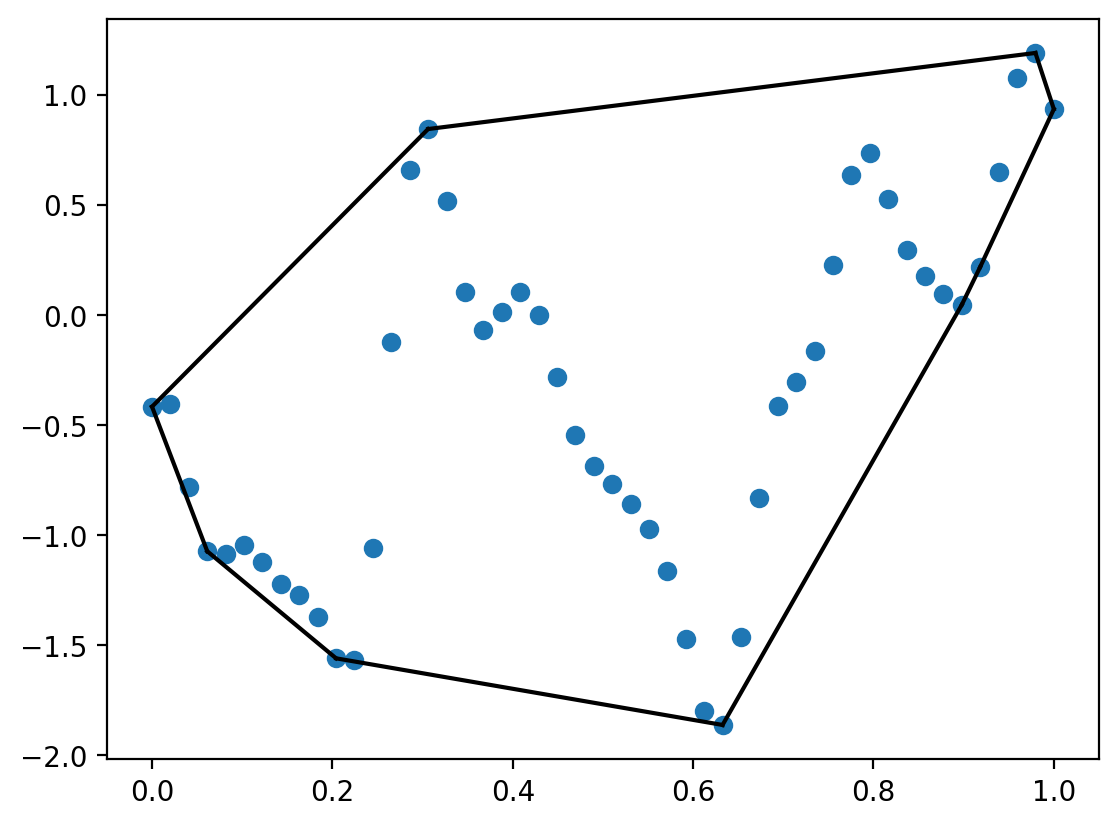

In [19]:
plt.scatter(design_space, true_y)

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    
#result = np.array([v-1 for v in hull.vertices if 0 < v <= N])

#plt.plot(design_space[result], true_y[result])

In [20]:
hull.vertices.sort()
np.maximum(true_y[0], true_y[-1]) ## only in 1 dimensions

true_y[hull.vertices] >= np.minimum(true_y[0], true_y[-1]) ## only in 1 dimensions

Array([ True, False, False,  True, False,  True,  True,  True,  True],      dtype=bool)

In [21]:
hull.vertices

array([ 0,  3, 10, 15, 31, 44, 45, 48, 49], dtype=int32)

In [22]:
convex_envelope(design_space, true_y)

array([[ 0,  3, 10, 31, 44, 45, 49]])

In [23]:
N = len(design_space)

result = [v-1 for v in hull.vertices if 0 < v <= N]

In [24]:
result

[2, 9, 14, 30, 43, 44, 47, 48]

In [25]:
%timeit convelope(design_space, true_y)

841 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
%timeit convex_envelope(design_space, true_y)

646 µs ± 4.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
convex_envelope(design_space, true_y)

array([[ 0,  3, 10, 31, 44, 45, 49]])

In [28]:
con

NameError: name 'con' is not defined

/var/folders/tb/bspns4bn3530r8v6y6y2pp480000gn/T/ipykernel_3160/3501196281.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)


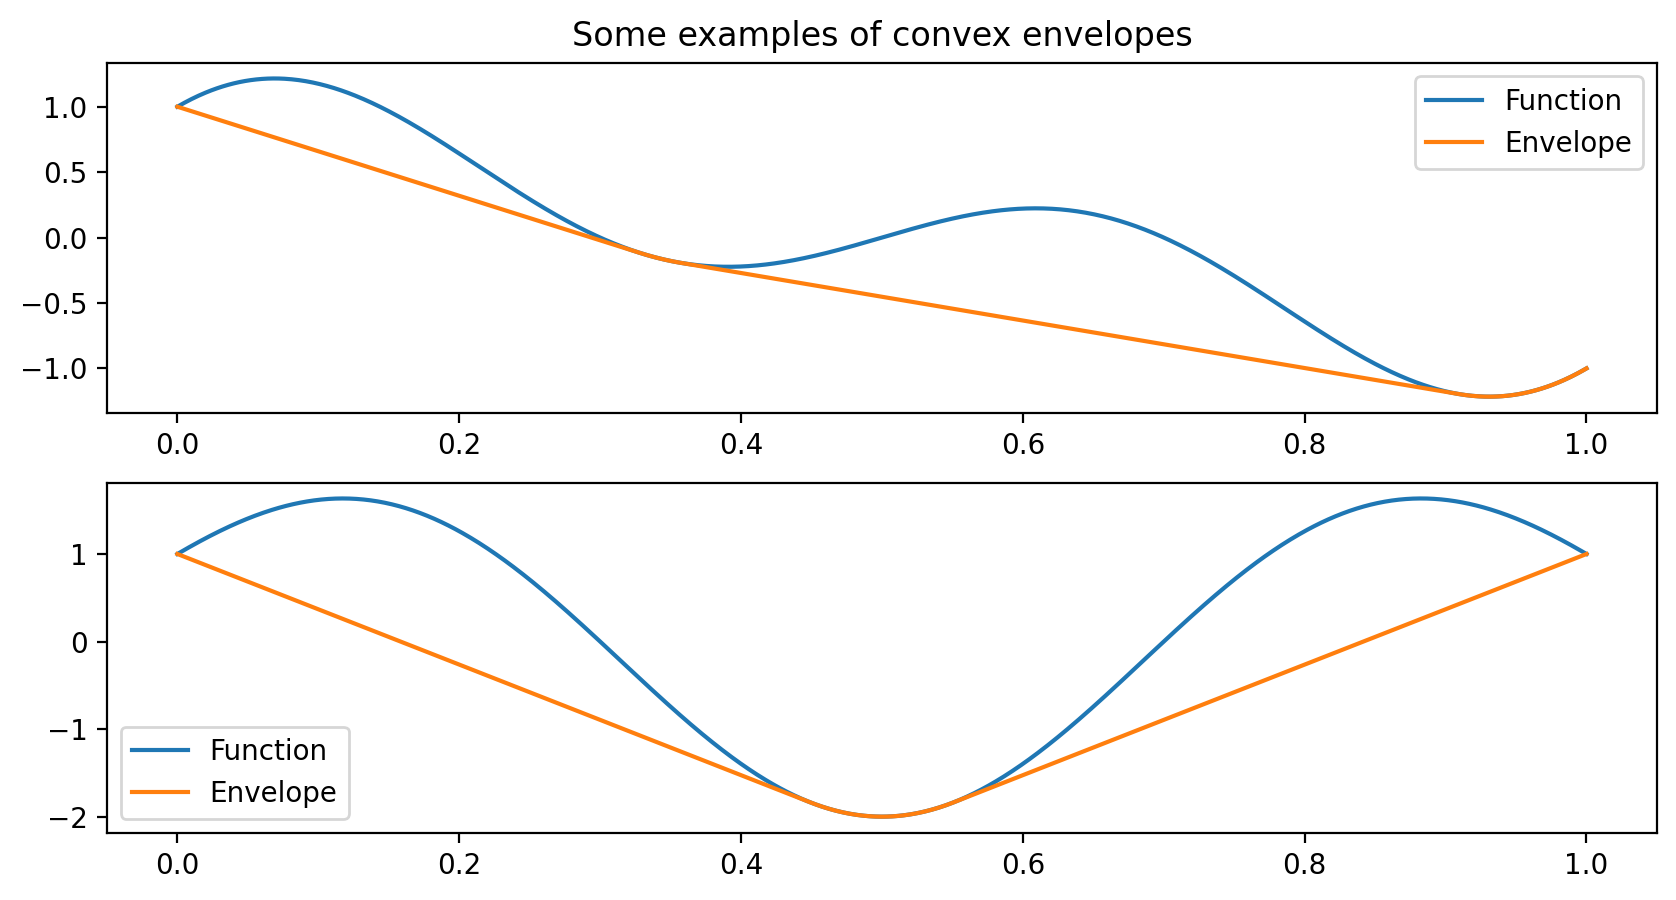

In [29]:
N = 1000

x = np.linspace(0., 1., N)

f1 = np.sin(2. * np.pi * x) + np.cos(3. * np.pi * x)
f2 = np.cos(2. * np.pi * x) + np.sin(3. * np.pi * x)
f = np.stack((f1, f2))

envelopes = convex_envelope(x, f)

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.title('Some examples of convex envelopes')
plt.plot(x, f[0, :], label='Function')
plt.plot(x[envelopes[0]], f[0, envelopes[0]], label='Envelope')
plt.legend()
plt.subplot(212)
plt.plot(x, f[1, :], label='Function')
plt.plot(x[envelopes[1]], f[1, envelopes[1]], label='Envelope')
plt.legend();

In [30]:
x[envelopes[0]]

array([0.        , 0.32832833, 0.32932933, 0.33033033, 0.33133133,
       0.33233233, 0.33333333, 0.33433433, 0.33533534, 0.33633634,
       0.33733734, 0.33833834, 0.33933934, 0.34034034, 0.34134134,
       0.34234234, 0.34334334, 0.34434434, 0.34534535, 0.34634635,
       0.34734735, 0.34834835, 0.34934935, 0.35035035, 0.35135135,
       0.35235235, 0.35335335, 0.35435435, 0.35535536, 0.35635636,
       0.35735736, 0.90890891, 0.90990991, 0.91091091, 0.91191191,
       0.91291291, 0.91391391, 0.91491491, 0.91591592, 0.91691692,
       0.91791792, 0.91891892, 0.91991992, 0.92092092, 0.92192192,
       0.92292292, 0.92392392, 0.92492492, 0.92592593, 0.92692693,
       0.92792793, 0.92892893, 0.92992993, 0.93093093, 0.93193193,
       0.93293293, 0.93393393, 0.93493493, 0.93593594, 0.93693694,
       0.93793794, 0.93893894, 0.93993994, 0.94094094, 0.94194194,
       0.94294294, 0.94394394, 0.94494494, 0.94594595, 0.94694695,
       0.94794795, 0.94894895, 0.94994995, 0.95095095, 0.95195

In [31]:
f[0, envelopes[0]]

array([ 1.        , -0.11756934, -0.12095907, -0.12429461, -0.1275758 ,
       -0.13080251, -0.1339746 , -0.13709194, -0.14015442, -0.14316191,
       -0.14611432, -0.14901153, -0.15185346, -0.15464001, -0.15737111,
       -0.16004668, -0.16266665, -0.16523096, -0.16773955, -0.17019237,
       -0.17258939, -0.17493057, -0.17721587, -0.17944528, -0.18161878,
       -0.18373636, -0.18579802, -0.18780376, -0.18975359, -0.19164753,
       -0.1934856 , -1.1951659 , -1.19697937, -1.19871282, -1.20036584,
       -1.20193801, -1.20342893, -1.2048382 , -1.20616543, -1.20741023,
       -1.20857223, -1.20965104, -1.2106463 , -1.21155765, -1.21238474,
       -1.21312722, -1.21378475, -1.21435699, -1.21484362, -1.21524432,
       -1.21555876, -1.21578666, -1.21592769, -1.21598158, -1.21594803,
       -1.21582676, -1.21561751, -1.21532001, -1.21493399, -1.21445921,
       -1.21389542, -1.21324239, -1.21249988, -1.21166767, -1.21074556,
       -1.20973332, -1.20863076, -1.20743768, -1.20615391, -1.20

In [32]:
def get_tight(design_space, true_y):
    points = np.hstack([design_space, true_y[:, np.newaxis]])
    hull = ConvexHull(points)
    s = np.zeros(len(design_space))
    s[hull.vertices] = 1
    return s

In [33]:
get_tight(design_space, true_y)

array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.])

In [34]:
ConvexHull(jnp.array(points)).vertices

array([15,  0,  3, 10, 31, 44, 45, 49, 48], dtype=int32)

## 2D

In [35]:
n_grid = 11

nx, ny = (n_grid, n_grid)
x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
xv, yv = jnp.meshgrid(x, y)
train_x = jnp.array([xv.flatten(),yv.flatten()]).T
# filter out points that are greater than 1
design_space = train_x[train_x.sum(1) <= 1]
pts = []
for x in design_space:
    pts.append(jnp.array([x[0], x[1], 1-x.sum()]))
    
knot_N = len(design_space)

#set seed
seed = 5
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# generate energies
true_y, true_envelope = generate_true_function(design_space, knot_N)

# compute tight points w.r.t. generated data
tights = (true_y - true_envelope) <= 1e-3
tight_designs = design_space[tights.ravel(),:]
tight_pts = []
for x in tight_designs:
    tight_pts.append(jnp.array([x[0], x[1], 1-x.sum()]))

# observations at each vertex and roughly in the middle
train_x = jnp.array([design_space[0], design_space[10], design_space[24], design_space[-1]])
train_y = jnp.array([true_y[0], true_y[10], true_y[24], true_y[-1]])
data = (train_x, train_y); #dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])

In [36]:
%timeit convelope(design_space, true_y)

96.1 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%timeit is_tight(design_space, true_y)

NameError: name 'is_tight' is not defined

In [ ]:
%timeit convex_envelope(design_space, true_y)

In [ ]:
chull = convelope(design_space, true_y)

In [ ]:
chull2 = np.array(convex_envelope(design_space, true_y)[0])

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(design_space[:,0], design_space[:,1], true_y, linewidth=0, antialiased=False, alpha=0.7)
ax.plot_trisurf(design_space[:,0], design_space[:,1], chull.ravel(), linewidth=0, antialiased=False, alpha=0.7)

ax.set_xlabel("$x$"); ax.set_ylabel("$1-x$"); ax.set_zlabel("energy")

In [ ]:
design_space.shape[1]

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(design_space[:,0], design_space[:,1], true_y, linewidth=0, antialiased=False, alpha=0.7)
ax.plot_trisurf(design_space[chull2,0], design_space[chull2,1], true_y[chull2], linewidth=0, antialiased=False, alpha=0.7)

ax.set_xlabel("$x$"); ax.set_ylabel("$1-x$"); ax.set_zlabel("energy")

In [ ]:
def convex_envelope(x, fs):
    """Computes convex envelopes of M functions which share a common grid.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (M, N)-matrix.
    The i-th function is given by the pairs (x[0], fs[i, 0]), ..., (x[N-1], fs[i, N-1]).
    The envelopes are returned as a list of lists.
    The i-th list is of the form [j_1, j_2, ..., j_n] where (X[j_k], fs[i, j_k]) is a point in the envelope.
    
    Keyword arguments:
    x  -- A shape=(N,D) numpy array.
    fs -- A shape=(M,N) or shape=(N,) numpy array."""
    
    #assert(len(fs.shape) <= 2)
    if len(fs.shape) == 1: fs = np.reshape(fs, (-1, fs.shape[0]))
    M, N = fs.shape
    
    assert(len(x.shape) <= 2)
    if len(x.shape) == 1: x = np.reshape(x, (-1, 1))
    assert(x.shape[0] == N)
    D = x.shape[1]
    
    fs_pad = np.empty((M, N+2))
    fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1. ## TODO: can't do this
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    results = []
    for i in range(M):
        epi = np.column_stack((x_pad, fs_pad[i, :]))
        hull = ConvexHull(epi)
        result = [v-1 for v in hull.vertices if 0 < v <= N]
        result.sort()
        results.append(np.array(result))
    
    return np.array(results)

In [ ]:
convex_envelope(points[:, :-1], points[:, -1])

In [ ]:
points[:, :-1].shape

In [ ]:
true_y.shape

In [ ]:
def is_vertex(points):
    N, D = points.shape
    #vertices = ConvexHull(points).vertices
    vertices = convex_envelope(points[:, :-1], points[:, -1])[0]
    s = np.zeros(N)
    s[vertices] = 1
    return s
    
    
def is_tight(design_space, true_y):

    points = jnp.hstack([design_space, true_y[:, jnp.newaxis]])
    #hull = ConvexHull(points)
    _scipy_hull = lambda points: is_vertex(points) #.astype(points.dtype)
    #s = np.zeros(len(design_space))
    #s[hull.vertices] = 1

    result_shape_dtype = jax.ShapeDtypeStruct(
          shape=jnp.broadcast_shapes(true_y.shape),
          dtype='float64')

    return jax.pure_callback(_scipy_hull, result_shape_dtype, points, vectorized=True)

In [ ]:
is_tight(design_space, true_y)

In [ ]:
chull2[0]

In [ ]:
true_y[chull2]

In [ ]:
def jv(v, z):
    import scipy
    v, z = jnp.asarray(v), jnp.asarray(z)

    # Require the order v to be integer type: this simplifies
    # the JVP rule below.
    assert jnp.issubdtype(v.dtype, jnp.integer)

    # Promote the input to inexact (float/complex).
    # Note that jnp.result_type() accounts for the enable_x64 flag.
    z = z.astype(jnp.result_type(float, z.dtype))

    # Wrap scipy function to return the expected dtype.
    _scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)

    # Define the expected shape & dtype of output.
    result_shape_dtype = jax.ShapeDtypeStruct(
      shape=jnp.broadcast_shapes(v.shape, z.shape),
      dtype=z.dtype)

    # We use vectorize=True because scipy.special.jv handles broadcasted inputs.
    return jax.pure_callback(_scipy_jv, result_shape_dtype, v, z, vectorized=True)

In [ ]:
import scipy

In [ ]:
v = jnp.asarray(1)
z = jnp.arange(5.0)

_scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)

result_shape_dtype = jax.ShapeDtypeStruct(
      shape=jnp.broadcast_shapes(v.shape, z.shape),
      dtype=z.dtype)

output = jax.pure_callback(_scipy_jv, result_shape_dtype, v, z, vectorized=True)

In [ ]:
z.shape

In [ ]:
_scipy_jv(1, z).shape

In [ ]:
from functools import partial
j1 = partial(jv, 1)
z = jnp.arange(5.0)
print(jax.vmap(j1)(z))


In [ ]:
def get_tight(design_space, true_y):
    design_np = np.array(design_space)
    true_y_np = np.array(true_y)
    points = np.hstack([design_np, true_y_np[:, np.newaxis]])
    
    _scipy_hull = lambda points: ConvexHull(points).astype(points.dtype)
    #_scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)
    s = np.zeros(len(design_space))
    s[np.array(hull.vertices)] = 1
    return jnp.array(s)

In [ ]:
_scipy_hull = lambda points: ConvexHull(points).astype(points.dtype)

In [ ]:
wrap_get_tight = lambda a, b: jnp.array(get_tight(a, b))

In [38]:
output = wrap_get_tight(design_space, true_y)

get_tight_jax = jax.vmap(wrap_get_tight, in_axes=(0,None))

NameError: name 'wrap_get_tight' is not defined

In [39]:
all_designs = jnp.array([design_space, design_space])
all_ys = jnp.array([true_y, true_y])

In [40]:
np.array(design_space)

array([[0. , 0. ],
       [0.1, 0. ],
       [0.2, 0. ],
       [0.3, 0. ],
       [0.4, 0. ],
       [0.5, 0. ],
       [0.6, 0. ],
       [0.7, 0. ],
       [0.8, 0. ],
       [0.9, 0. ],
       [1. , 0. ],
       [0. , 0.1],
       [0.1, 0.1],
       [0.2, 0.1],
       [0.3, 0.1],
       [0.4, 0.1],
       [0.5, 0.1],
       [0.6, 0.1],
       [0.7, 0.1],
       [0.8, 0.1],
       [0.9, 0.1],
       [0. , 0.2],
       [0.1, 0.2],
       [0.2, 0.2],
       [0.3, 0.2],
       [0.4, 0.2],
       [0.5, 0.2],
       [0.6, 0.2],
       [0.7, 0.2],
       [0.8, 0.2],
       [0. , 0.3],
       [0.1, 0.3],
       [0.2, 0.3],
       [0.3, 0.3],
       [0.4, 0.3],
       [0.5, 0.3],
       [0.6, 0.3],
       [0.7, 0.3],
       [0. , 0.4],
       [0.1, 0.4],
       [0.2, 0.4],
       [0.3, 0.4],
       [0.4, 0.4],
       [0.5, 0.4],
       [0.6, 0.4],
       [0. , 0.5],
       [0.1, 0.5],
       [0.2, 0.5],
       [0.3, 0.5],
       [0.4, 0.5],
       [0.5, 0.5],
       [0. , 0.6],
       [0.1,